In [1]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 86.3MB 133kB/s 
     |████████████████████████████████| 3.8MB 44.7MB/s 
     |████████████████████████████████| 450kB 50.0MB/s 
     |████████████████████████████████| 81kB 10.0MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np
tf.__version__

'2.0.0'

In [0]:
num_classes = 10 # total classes (0-9 digits).
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
learning_rate = 0.1
training_steps = 2000
batch_size = 256
display_step = 100

n_hidden_1 = 128
n_hidden_2 = 256

In [3]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [0]:
class NNet(Model):
    def __init__(self):
        super(NNet, self).__init__()
        self.fc1 = layers.Dense(n_hidden_1, activation=tf.nn.relu)
        self.fc2 = layers.Dense(n_hidden_2, activation=tf.nn.relu)
        self.out = layers.Dense(num_classes, activation=tf.nn.softmax)

    def call(self, x, is_training = False):
        x = self.fc1(x)
        x = self.out(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x
nn = NNet()   

In [0]:
def cross_entropy(x,y):
    y = tf.cast(y, tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    return tf.reduce_mean(loss)

def acc(y_pred, y_true):
    corr_pred = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(corr_pred, tf.float32), axis=-1)

optimizer = tf.optimizers.SGD(learning_rate)

In [0]:
def run_optimization(x,y):
    with tf.GradientTape() as g:
        pred = nn(x, is_training=True)
        loss = cross_entropy(pred, y)
    trainable_vars = nn.trainable_variables
    gradients = g.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))

In [8]:
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    run_optimization(batch_x, batch_y)

    if step % display_step == 0:
        pred = nn(batch_x, is_training=True)
        loss = cross_entropy(pred, batch_y)
        accu = acc(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, accu))

step: 100, loss: 2.042239, accuracy: 0.523438
step: 200, loss: 1.779905, accuracy: 0.761719
step: 300, loss: 1.722709, accuracy: 0.792969
step: 400, loss: 1.710187, accuracy: 0.789062
step: 500, loss: 1.679607, accuracy: 0.800781
step: 600, loss: 1.675413, accuracy: 0.812500
step: 700, loss: 1.631944, accuracy: 0.871094
step: 800, loss: 1.703237, accuracy: 0.773438
step: 900, loss: 1.675799, accuracy: 0.804688
step: 1000, loss: 1.720828, accuracy: 0.757812
step: 1100, loss: 1.659075, accuracy: 0.828125
step: 1200, loss: 1.676596, accuracy: 0.804688
step: 1300, loss: 1.694635, accuracy: 0.789062
step: 1400, loss: 1.622961, accuracy: 0.847656
step: 1500, loss: 1.643426, accuracy: 0.824219
step: 1600, loss: 1.650906, accuracy: 0.824219
step: 1700, loss: 1.619243, accuracy: 0.855469
step: 1800, loss: 1.690694, accuracy: 0.773438
step: 1900, loss: 1.645460, accuracy: 0.824219
step: 2000, loss: 1.670403, accuracy: 0.792969


In [9]:
pred = nn(x_test, is_training=False)
print(acc(pred, y_test).numpy())

0.8396


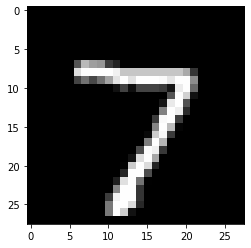

Model prediction: 7


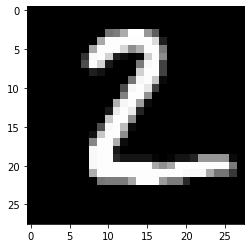

Model prediction: 2


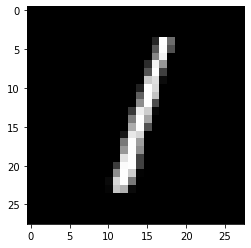

Model prediction: 1


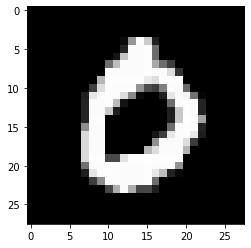

Model prediction: 0


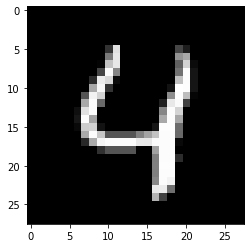

Model prediction: 4


In [13]:
import matplotlib.pyplot as plt

n_images = 5
test_images = x_test[:n_images]
predictions = nn(test_images)

for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))